<a href="https://colab.research.google.com/github/rohithay/bunnie/blob/main/Movies_and_TV_Shows_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
shivamb_netflix_shows_path = kagglehub.dataset_download('shivamb/netflix-shows')

print('Data source import complete.')


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/netflix-shows/netflix_titles.csv


In [ ]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from ipywidgets import interact, widgets

# Load the dataset (Kaggle path)
df = pd.read_csv('/kaggle/input/netflix-shows/netflix_titles.csv')

# --- DATA CLEANING ---
# Convert date_added to datetime and extract year
df['date_added'] = pd.to_datetime(df['date_added'].str.strip())
df['year_added'] = df['date_added'].dt.year

# Fill missing values for cleaner visuals
df['director'] = df['director'].fillna('Unknown Director')
df['cast'] = df['cast'].fillna('Unknown Cast')
df['country'] = df['country'].fillna('Unknown Country')

# Handle missing ratings
df['rating'] = df['rating'].fillna('NR') # No Rating

print(f"Dataset Loaded: {df.shape[0]} rows and {df.shape[1]} columns.")
df.head(3)

Dataset Loaded: 8807 rows and 13 columns.


,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,year_added
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,Unknown Cast,United States,2021-09-25,2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm...",2021.0
1,s2,TV Show,Blood & Water,Unknown Director,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,2021-09-24,2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t...",2021.0
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",Unknown Country,2021-09-24,2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...,2021.0


In [ ]:
def search_netflix(search_term):
    if len(search_term) < 3:
        return "Please enter at least 3 characters to search."

    # Search in Title, Cast, and Director
    results = df[
        df['title'].str.contains(search_term, case=False) |
        df['cast'].str.contains(search_term, case=False) |
        df['director'].str.contains(search_term, case=False)
    ]

    print(f"Found {len(results)} matches for '{search_term}':")
    return results[['title', 'type', 'release_year', 'rating', 'cast']].head(10)

interact(search_netflix, search_term="Blood & Water");

interactive(children=(Text(value='Blood & Water', description='search_term'), Output()), _dom_classes=('widget…

In [ ]:
# Create a count of Movies vs TV Shows per year
growth = df.groupby(['year_added', 'type']).size().reset_index(name='Count')

fig = px.area(growth, x="year_added", y="Count", color="type",
             title='Cumulative Growth of Netflix Content (By Year Added)',
             color_discrete_map={'Movie': '#E50914', 'TV Show': '#000000'},
             template='plotly_white')

fig.update_layout(xaxis_title="Year Added", yaxis_title="Number of Titles")
fig.show()

In [ ]:
# 1. Split the strings into lists
df_genres = df.copy()
df_genres['genre_list'] = df_genres['listed_in'].str.split(', ')

# 2. "Explode" the dataframe so each genre gets its own row
df_exploded = df_genres.explode('genre_list')

# 3. Plot the Top 15 Genres
top_genres = df_exploded['genre_list'].value_counts().head(15).reset_index()
top_genres.columns = ['Genre', 'Total Count']

fig_genres = px.bar(top_genres, x='Total Count', y='Genre',
                    orientation='h', title='Top 15 Most Frequent Genres',
                    color='Total Count', color_continuous_scale='Reds')

fig_genres.update_layout(yaxis={'categoryorder':'total ascending'})
fig_genres.show()

In [ ]:
# Map by country
df['first_country'] = df['country'].str.split(',').str[0]

country_counts = df['first_country'].value_counts().reset_index()
country_counts.columns = ['Country', 'Title Count']

fig_map = px.choropleth(country_counts, locations="Country",
                        locationmode='country names',
                        color="Title Count",
                        hover_name="Country",
                        title="Global Distribution of Netflix Content",
                        color_continuous_scale='OrRd')
fig_map.show()

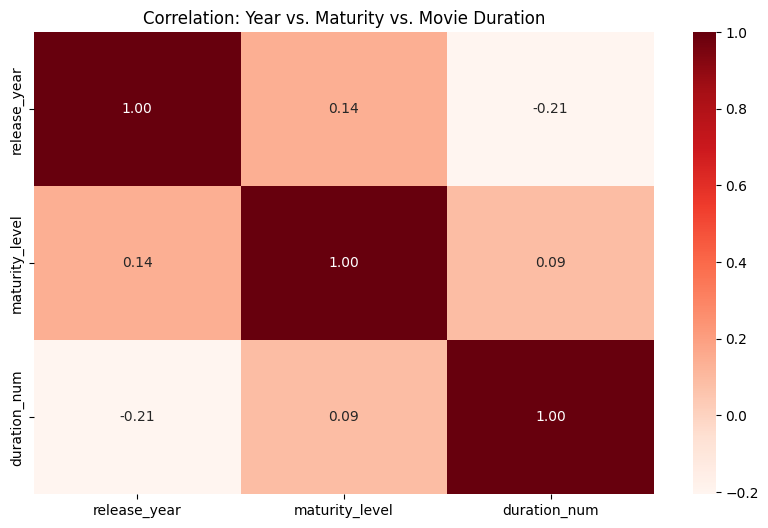

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# --- 1. Clean Duration ---
# We split "90 min" or "2 Seasons" and take the number
df['duration_num'] = df['duration'].str.split(' ').str[0].fillna(0).astype(int)

# --- 2. Encode Ratings ---
# We map ratings to a numerical "Maturity Level" (1 = Kids, 5 = Adults)
rating_map = {
    'G': 1, 'TV-G': 1, 'TV-Y': 1,
    'PG': 2, 'TV-PG': 2, 'TV-Y7': 2, 'TV-Y7-FV': 2,
    'PG-13': 3, 'TV-14': 3,
    'R': 4, 'NC-17': 4, 'TV-MA': 5
}
df['maturity_level'] = df['rating'].map(rating_map).fillna(0)

# --- 3. Plotting the Heatmap ---
# We look at Release Year, Maturity, and Duration
corr_data = df[df['type'] == 'Movie'][['release_year', 'maturity_level', 'duration_num']]
plt.figure(figsize=(10, 6))
sns.heatmap(corr_data.corr(), annot=True, cmap='Reds', fmt='.2f')
plt.title('Correlation: Year vs. Maturity vs. Movie Duration')
plt.show()

In [ ]:
from textblob import TextBlob

# Function to get sentiment polarity (-1 is very negative, 1 is very positive)
def get_sentiment(text):
    return TextBlob(text).sentiment.polarity

# Apply to descriptions
df['sentiment_score'] = df['description'].apply(get_sentiment)

# --- Plot Sentiment Trend Over Time ---
sentiment_trend = df.groupby('release_year')['sentiment_score'].mean().reset_index()

fig_sent = px.line(sentiment_trend[sentiment_trend['release_year'] > 2000],
                  x='release_year', y='sentiment_score',
                  title='Average Sentiment of Netflix Descriptions (2000-2021)',
                  labels={'sentiment_score': 'Sentiment (Higher = More Positive)'},
                  template='plotly_dark')

fig_sent.add_hline(y=0, line_dash="dash", line_color="white", annotation_text="Neutral Sentiment")
fig_sent.show()

In [ ]:
keywords = ['action', 'thriller', 'crime', 'murder', 'battle', 'war', 'spy']

# Count how many of these keywords appear in each description
df['action_intensity'] = df['description'].str.lower().apply(lambda x: sum(1 for word in keywords if word in x))

# Group by year to see the trend
action_trend = df.groupby('release_year')['action_intensity'].mean().reset_index()

fig_action = px.bar(action_trend[action_trend['release_year'] > 2010],
                    x='release_year', y='action_intensity',
                    title='Average "Action Keyword" Frequency in Descriptions',
                    color='action_intensity', color_continuous_scale='YlOrRd')
fig_action.show()

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Combine genres and descriptions for a richer "feature" set
df['cluster_input'] = df['listed_in'] + " " + df['description']

# Convert text to numbers (limiting to top 2000 words to keep it fast)
tfidf = TfidfVectorizer(stop_words='english', max_features=2000)
matrix = tfidf.fit_transform(df['cluster_input'].fillna(''))

print(f"Feature Matrix Shape: {matrix.shape}")

Feature Matrix Shape: (8807, 2000)


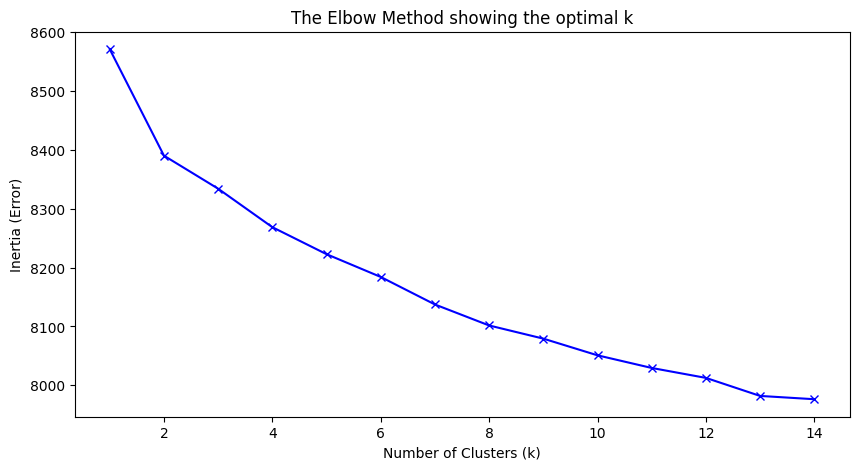

In [ ]:
import matplotlib.pyplot as plt

inertia = []
K_range = range(1, 15)
for k in K_range:
    model = KMeans(n_clusters=k, random_state=42, n_init=10)
    model.fit(matrix)
    inertia.append(model.inertia_)

plt.figure(figsize=(10, 5))
plt.plot(K_range, inertia, 'bx-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (Error)')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [ ]:
# Let's assume 10 clusters based on the elbow plot
k = 10
model = KMeans(n_clusters=k, random_state=42, n_init=10)
df['cluster_label'] = model.fit_transform(matrix).argmin(axis=1)

# Reduce dimensions to 2D for visualization
pca = PCA(n_components=2)
pca_features = pca.fit_transform(matrix.toarray())
df['x'] = pca_features[:, 0]
df['y'] = pca_features[:, 1]

# Plotly Interactive Map of Clusters
fig_clusters = px.scatter(df, x='x', y='y', color='cluster_label',
                         hover_data=['title', 'listed_in'],
                         title='Netflix Content Clusters (Visualized via PCA)',
                         color_continuous_scale='Turbo',
                         template='plotly_dark')
fig_clusters.show()

# Print top genres for each cluster to identify the "theme"
for i in range(k):
    print(f"--- Cluster {i} ---")
    print(df[df['cluster_label'] == i]['listed_in'].value_counts().head(3))
    print("\n")

--- Cluster 0 ---
listed_in
Docuseries                         82
Crime TV Shows, Docuseries         50
Docuseries, Science & Nature TV    38
Name: count, dtype: int64


--- Cluster 1 ---
listed_in
International TV Shows, TV Dramas                         117
Crime TV Shows, International TV Shows, TV Dramas         110
International TV Shows, Romantic TV Shows, TV Comedies     94
Name: count, dtype: int64


--- Cluster 2 ---
listed_in
Dramas, International Movies                        362
Comedies, Dramas, International Movies              269
Dramas, Independent Movies, International Movies    252
Name: count, dtype: int64


--- Cluster 3 ---
listed_in
Stand-Up Comedy                              334
Stand-Up Comedy & Talk Shows, TV Comedies     27
Music & Musicals, Stand-Up Comedy              7
Name: count, dtype: int64


--- Cluster 4 ---
listed_in
Documentaries                          358
Documentaries, International Movies    186
Documentaries, Music & Musicals         82
Name